### Purpose
The purpose of this code is to reproduce the response of a superconducting quantum interference device (SQUID) by numerical simulation. We will numerical method, namely Runge-Kutta 4th order fixed-time step modified to accept a noise signal, to simulate the average voltage response of a pair of resistively shunted Josephson junctions in parrallel, with Johnson noise in the shunt. We wish to make the model dependent on physical parameters of the circuit (critical current and symmetry considerations in shunt resistance and branch inductances) and dependent on input parameters as the applied flux and bias current placed across the circuit. This model will be useful in basic investigation of circuit behavior and in fitting physical parameters to real circuits.
![training_VPhi_3D.jpg](training_VPhi_3D.jpg)

### The Model
The model used here is from Tesche-Clarke 1977, section 2. The model is developed by combining the Josephson effects of two resistively shunted Josephson junctions arranged on a superconductiong ring. The junctions are in parrallel with respect to the bias current and voltage across the circuit.
![squid_circuit.jpg](squid_circuit.jpg)
Having combined effects and converte to dimensionless units, the needed system of equations is found to be:

$$j = (\delta_1 - \delta_2 - 2\pi\phi_a)/\pi \beta{}_L - \eta i /2$$

$$v = \frac{1+\eta}{2}\frac{d\delta_1}{d\theta} + \frac{1-\eta}{2}\frac{d\delta_2}{d\theta}$$

$$\frac{d\delta_1}{d\theta} = \frac{i/2 - j-(1-\alpha)\sin{\delta_1}}{1-\rho} + v_{N1}$$

$$\frac{d\delta_2}{d\theta} = \frac{i/2 - j-(1+\alpha)\sin{\delta_2}}{1+\rho} + v_{N2}$$

#### Parameters

$I_0$ - critical current of each junction

$\Phi_0$ - flux quantum

$R$ - total resistance of circuit (shunts)

$\theta$ - dimensionless time [$\Phi_0/2\pi I_0 R$]

$j$ - circulating current in superconducting ring [$I_0$]

$\delta_{1,2}$ - phase difference across each junction

$\phi_a$ - applied flux [$\Phi_0$]

$\eta$ - inductance symmetry parameter (0 to 1)

$v$ - voltage across circuit [$I_0 R$]

$i$ - applied bias current [$I_0$]

$\alpha$ - critical current symmetry parameter (0 to 1)

$\rho$ - resistance symmetry parameter (0 to 1)

$v_{N1,2}$ - noise signal, random Gaussian distributed voltage value [$I_0 R$]

This model considers the Johnson noise in the resistive shunts. This effect is temperature dependent and can be described by the parameter $\Gamma$, which is temperature dependent. The value will be supplied by the user for our model rather than derived. The random, Gaussian distributed voltage noise values have average value 0 and standard deviation* $\sigma_{v_N}=\sqrt{2\Gamma/\Delta\theta}$. (more on this in the numrical method section)

### Numerical Method
#### Modified Runge-Kutta 4th order, fixed-time step

We will use a modified RK4 fixed-time step method to solve the time series voltage output for the system. The fixed step size is chosen to simplify the modification of the method to utilize the noise signals, $v_{N1,2}$. The RK4 method will use half-time steps, meaning the method will calculate values at the current moment, halfway to the next time output, and at the next time point to output the value at the next time point. At the first iteration, the method will use $t_0, t_{1/2}, t_1$ to output $v_1$. Then, it will use $t_1, t_{3/2}, t_2$ to output $v_2$. Then we need to keep track of and pass noise values $v_n$ such that the RK4 method has available $v_0, v_1, v_2$ at $t_0$ to return $v_1$ and then pass $v_2, v_3, v_4$ at $t_1$ to return $v_2$, and so on.

Because we are creating and using twice as many noise values as voltage outputs, we need to modify the standard deviation quoted above in the model section. Since each noise value occurs at a half time step, we have

$$\sigma_{v_N} = \sqrt{\frac{2\Gamma}{\frac{\Delta \theta}{2}} }=\sqrt{ \frac{4\Gamma}{\Delta \theta}}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import scipy.signal as sig
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import interpolate

#### Modified RK4
Here we employ a standard RK4 method modified to pass noise values to the derivative function at each iteration. We need to pass three noise values for each junction at each iteration, namely the present time noise values, the values at a half-time step away, and the values at a full time step away. We have to supply the correct values at each iteration, meaning the last pair of noise values passed for the present iteration must also be the first set of noise values passed at the next iteration. We simply define those as supplied parameters to the solver, and let them drop through to the derivative functions as appropriate.

For the purposes of this notebook, I have left all input parameters as scalars rather than combine them as vectors where it may be more concise.

In [2]:
def noisyRK4(s,th,alpha,beta,eta,rho,i,phia,tau,derivsRK,vn10,vn20,vn11,vn21,vn12,vn22):
"""Return time series voltage values for SQUID circuit
DEPENDENCIES
    derivsRK - definition of derivatives
INPUTS
    s - state vector, [delta_1, delta_2]
    th - dimensionless time
    alpha - critical current symmetry parameter (0 to 1)
    beta - inductance constant
    eta - inductance symmetry parameter (0 to 1)
    rho - resistance symmetry parameter (0 to 1)
    i - dimensionless bias current
    phia - dimensionless applied flux
    tau - time step size
    derivsRK - difined fn returning derivatives
    vn10,vn20 - voltage noise values for present moment, junciton 1 an 2
    vn11,vn21 - voltage noise values for half-step from now
    vn12,vn22 - voltage noise values for full step from now
OUTPUT
    sout - state vector, updated values at next moment in time"""
    
    half_tau = 0.5*tau
    
    F1 = derivsRK(s,th,alpha,beta,eta,rho,i,phia,vn10,vn20)             # use present voltage noise
    th_half = th + half_tau
    stemp = s + half_tau*F1
    
    F2 = derivsRK(stemp,th_half,alpha,beta,eta,rho,i,phia,vn11,vn21)    # use half-tau step voltage noise
    stemp = s + half_tau*F2
    
    F3 = derivsRK(stemp,th_half,alpha,beta,eta,rho,i,phia,vn11,vn21)    # use half-tau step voltage noise
    th_full = th + tau
    stemp = s + tau*F3
    
    F4 = derivsRK(stemp,th_full,alpha,beta,eta,rho,i,phia,vn12,vn22)    # use full-tau step voltage noise
    sout = s + tau/6.*(F1 + F4 + 2.*(F2 + F3))
    return sout   

The function below is called by the modified RK4 above. It returns the calculated value of the derivative at a half-time step away or a full time step away as requested by the RK4. Noise values fall through from the RK4 to the function below.

In [3]:
def noisySQUIDrk(s,th,alpha,beta,eta,rho,i,phia,vn1,vn2):
"""Returns derivatives of the SQUID system
DEPENDENCIES
    numpy as np
INPUTS
    s - state vector, [delta_1, delta_2]
    th - dimensioless time
    alpha - critical current symmetry parameter (0 to 1)
    beta - inductance constant
    eta - inductance symmetry parameter (0 to 1)
    rho - resistance symmetry parameter (0 to 1)
    i - dimensionless bias current
    phia - dimensionless applied flux
    vn1 - voltage noise value at junction 1
    vn2 - voltage noise value at junction 2
OUTPUTS
    deriv - array of derivs, [ddelta_1/dth, ddelta_2/dth]"""

    # calculate the present circ. current for use below
    j = (s[0] - s[1] - 2*np.pi*phia)/(np.pi*beta) - eta*i/2
    
    # calculate the present value of the time derivatives of phases
    d1 = (.5*i-j-(1-alpha)*np.sin(s[0]))/(1-rho) + vn1 # ddel1/dth
    d2 = (.5*i+j-(1+alpha)*np.sin(s[1]))/(1+rho) + vn2 # ddel2/dth
    
    deriv = np.array([d1,d2])
    return(deriv)

We need a function to handle the solver. We need the handler to accept simulation parameters (number of steps, step size, initial conditions, physical parameters), create a set of noise values, create a data structure and populate with initial conditions. Then call the RK4 solver within a loop and store the output in an array which will be returned to the user.

In [4]:
def noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma):
"""Returns array of simulated output data for SQUID
DEPENDENCIES
    numpy as np
    noisyRK - RK4 solver modified to use noise
INPUTS
    nStep - number of time steps for which to give output
    tau - time step size
    s - starting state vector, [delta_1,delta_2]
    alpha - critical current symmetry parameter (0 to 1)
    beta - inductance constant
    eta - inductance symmetry parameter (0 to 1)
    rho - resistance symmetry parameter (0 to 1)
    i - dimensionless bias current
    phia - dimensionless applied flux
    Gamma - Johnson noise parameter
OUTPUT
    X - output array [[delta_1],[delta_3],[j],[v_1],[v_2],[v]]"""
    ## NOISE ##
    # set an appropriate variance based on Gamma.
    # variance is twice normal because freq of noise
    # is twice that of the sampling freq so that rk4 has
    # a noise value to use at each half tau step
    var = 4*Gamma/tau
    sd = var**.5
    
    # make two time series of noise voltages
    vn1 = np.zeros(2*nStep+1)
    vn2 = np.zeros(2*nStep+1)
    for ist in range(2*nStep+1):
        vn1[ist] = np.random.normal(0,sd)
        vn2[ist] = np.random.normal(0,sd)
    
    ## DATA STRUCTIRE, X[0:6,0:nStep*tau:tau] ##
    # going to keep: theta, d1, d2, j, ddelta_1/dth, ddelta_2/dth, v
    # X[0,:] = theta
    # X[1,:], X[2,:] = delta_1, delta_2 = s[0], s[1]
    # X[3,:] = j = (del10 - del20 - 2*np.pi*phia)/(np.pi*beta) - eta*i/2
    # X[4,:], X[5,:]  = ddelta_1/dtheta, ddelta_2/dtheta
    # = (i/2 -+ j0 -(1 -+ alpha)*np.sin(del10))/(1 -+ rho)
    # X[6,:] = v = (1+eta)*d10/2 + (1-eta)*d20/2
    
    th = 0
    X = np.zeros([7,nStep])
    # set initial conditions
    X[1,0] = s[0]
    X[2,0] = s[1]
    X[3,0] = (s[0] - s[1] - 2*np.pi*phia)/(np.pi*beta) - eta*i/2
    X[4,0] = (i/2 - X[3,0] -(1-alpha)*np.sin(s[0]))/(1-rho)
    X[5,0] = (i/2 + X[3,0] -(1+alpha)*np.sin(s[1]))/(1+rho)
    X[6,0] = (1+eta)*X[4,0]/2 + (1-eta)*X[5,0]/2
    
    ## For loop ##
    # Grab the appropriate voltage noise values to pass to rk4 solver;
    #     Each rk4 call needs the noise voltage now, at now+tau/2, and
    #     at now+tau.
    # Update state variable s[0:1] = <delta_1,delta_2> by calling the
    # noisyRK4() to get state values at next time step, now+tau
    # Update the data structure
    # Finally, update time theta to now+tau
    
    for iStep in range(1,nStep):
        vn10 = vn1[2*iStep-2]
        vn20 = vn2[2*iStep-2]
        vn11 = vn1[2*iStep-1]
        vn21 = vn2[2*iStep-1]
        vn12 = vn1[2*iStep]
        vn22 = vn2[2*iStep]
        
        #   noisyRK4(s,th,alpha,beta,eta,rho,i,phia,tau,derivsRK,vn10,vn20,vn11,vn21,vn12,vn22)
        s = noisyRK4(s,th,alpha,beta,eta,rho,i,phia,tau,noisySQUIDrk,vn10,vn20,vn11,vn21,vn12,vn22)
        
        X[0,iStep] = th
        X[1,iStep] = s[0]
        X[2,iStep] = s[1]
        X[3,iStep] = (s[0] - s[1] - 2*np.pi*phia)/(np.pi*beta) - eta*i/2
        X[4,iStep] = (i/2 - X[3,iStep] - (1-alpha)*np.sin(s[0]))/(1-rho)
        X[5,iStep] = (i/2 + X[3,iStep] - (1+alpha)*np.sin(s[1]))/(1+rho)
        X[6,iStep] = (1+eta)*X[4,iStep]/2 + (1-eta)*X[5,iStep]/2
        
        th = th + tau        
    return(X)    

We can test the basic function of the handler by using it to create a simple time series output for a fixed bias current and applied flux. We will specify the parameters needed explicitly and then include them as arguments in a call to the handler function. We then look at a simple plot of the time series voltage across the SQUID.

In [5]:
# noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma)
nStep = 8000
tau = 0.1
s = np.array([0.,0.])
alpha = 0.
beta = 1.
eta = 0.
rho = 0.
i = 1.5
phia = 0.5
Gamma = 0.05

In [11]:
# noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma)
SQ = noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma)

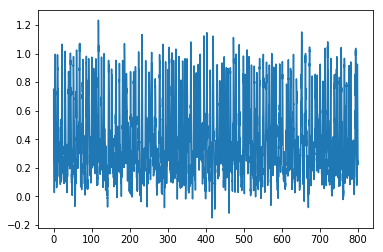

In [12]:
plt.plot(SQ[0,],SQ[6,])

To be useful in investigation and parameter fitting, we want to see a surface that represents the voltage response of the SQUID to a sweep of both bias current and applied flux. The characteristic frequency of a typical SQUID is in the megahertz. What we measure and use is actually the average value of that wildly AC signal. Then when we create a time series of voltage outputs, for these purposes we are interested in the average of those values.

To create the surface, we will create 1-D arrays of bias current values and applied flux values. We will then use two nested loops. The inner loop will sweep over applied flux, calling our handler function, and then averaging all the voltages and returning a single value. The outer loop will sweep over the given bias current values

The output will be a 2-D array of average voltage values. We can later combine our two 1-D arrays and one 2-D array to create the surface desired, $\bar{v}(i_{bias},\phi_a)$.

**Specifically** I need $i=\{0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0\}$ and $\phi_a=\{0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5\}$

We can define the required parameters below and call them as arguments to the handler calls.

In [6]:
# noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma)
nStep = 64000
tau = 0.1
s = np.array([0.,0.])
alpha = 0.
beta = 1.
eta = 0.
rho = 0.
Gamma = 0.05
i = np.arange(0.8,3.1,0.1)#i = np.arange(1,2.51,0.075)#i = np.arange(1,2.55,0.05)#i = np.arange(0.8,3.1,0.1)
phia = np.arange(0.,.55,.025)#phia = np.arange(.2,.31,.005)#phia = np.arange(0.,.5,.03125)#phia = np.arange(0.,.55,.025)

These simulations were getting very long, on the order of 30 minutes to an hour as I was trying to develop data sets dense enough, and averaged over a long enough time, to adequately investigate the nature of the surface in relatively fine detail.

The next bit of code is only related to drawing a progress bar as the calculation proceeds. The notebook cell magic %%time is also used to time the output.

In [ ]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [143]:
%%time 
# cell magic timer to see how long this takes...
m = len(i)
n = len(phia)
l = int(nStep*0.05)
N = m*n
vp = np.zeros([n,m]) # average v at fixed phia
iv = np.zeros([m,n]) # average v at fixed i

for j in range(0,m):
    for k in range(0,n):
        X = noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i[j],phia[k],Gamma)
        v = np.average(X[6,l:]) # average voltage
        vp[k,j] = v 
        iv[j,k] = v
    update_progress(j/m)
update_progress(1)

Wall time: 35min 8s


In [5]:
#np.savetxt("test.csv", vp, delimiter=",")
#np.savetxt("test.csv", iv, delimiter=",")
#vp = np.genfromtxt('vp.csv',delimiter=',')
#iv = np.genfromtxt('iv.csv',delimiter=',')

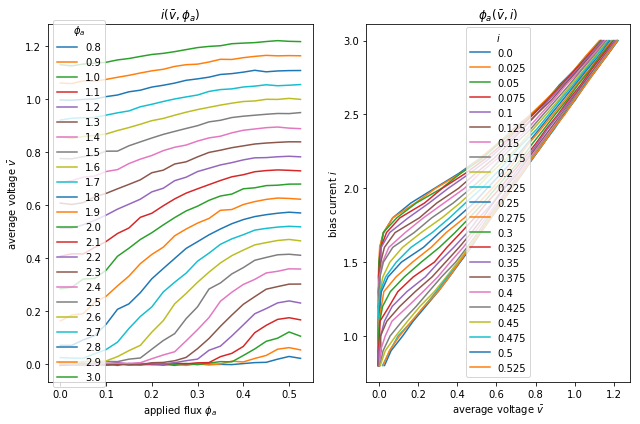

In [7]:
fig = plt.figure(figsize=[9,6])

ax1 = plt.subplot(1,2,1)
ax1.plot(phia,vp[:,0],label=round(i[0],2))
for h in range(1,len(vp[0,:])):
    ax1.plot(phia,vp[:,h],label=round(i[h],2))
ax1.set(title=r'$i(\bar{v},\phi_a)$',
        xlabel=r'applied flux $\phi_a$',
        ylabel=r'average voltage $\bar{v}$')
ax1.legend(loc=6,title=r'$\phi_a$')

ax2 = plt.subplot(1,2,2)
ax2.plot(vp[0,:],i,label=round(phia[0],3))
for h in range(1,len(vp[:,0])):
    ax2.plot(vp[h,:],i,label=round(phia[h],3))
ax2.set(title=r'$\phi_a(\bar{v},i)$',
        xlabel=r'average voltage $\bar{v}$',
        ylabel=r'bias current $i$')
ax2.legend(title=r'$i$')
fig.tight_layout()
fig.savefig('test.jpg')

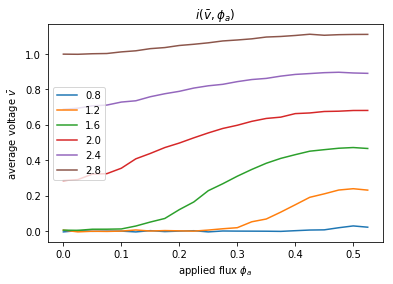

In [348]:
plt.plot(phia,vp[:,0],label=round(i[0],2))
plt.plot(phia,vp[:,4],label=round(i[4],2))
plt.plot(phia,vp[:,8],label=round(i[8],2))
plt.plot(phia,vp[:,12],label=round(i[12],2))
plt.plot(phia,vp[:,16],label=round(i[16],2))
plt.plot(phia,vp[:,20],label=round(i[20],2))
#for h in range(1,len(vp[0,:])):
    #plt.plot(phia,vp[:,h],label=round(i[h],2))
plt.title(r'$i(\bar{v},\phi_a)$')
plt.xlabel(r'applied flux $\phi_a$')
plt.ylabel(r'average voltage $\bar{v}$')
plt.legend(loc=6)

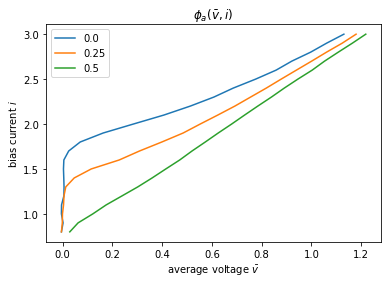

In [219]:
plt.plot(vp[0,:],i,label=round(phia[0],3))
plt.plot(vp[10,:],i,label=round(phia[10],3))
plt.plot(vp[20,:],i,label=round(phia[20],3))
#for h in range(1,len(vp[:,0])):
    #plt.plot(vp[h,:],i,label=round(phia[h],3))
plt.title(r'$\phi_a(\bar{v},i)$')
plt.xlabel(r'average voltage $\bar{v}$')
plt.ylabel(r'bias current $i$')
plt.legend()

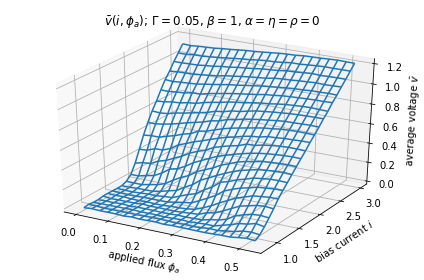

In [220]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x = np.copy(i)
y = np.copy(phia)
x, y = np.meshgrid(y, x)
z = np.copy(iv)
ax.plot_wireframe(x, y, z) # cmap='terrain'
# note the xlabel and ylabel are reversed, this is correct
ax.set(ylabel=r'bias current $i$',
       xlabel=r'applied flux $\phi_a$',
       zlabel=r'average voltage $\bar{v}$',
      title = r'$\bar{v}(i,\phi_a)$; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$')
fig.tight_layout()
fig.savefig('test.jpg')

In [8]:
## smooth and interpolate over a grid lx dense ##
l = 1
inew = np.arange(0.8,3.1,0.1/l)#inew = np.arange(1,2.55,0.05/l)#inew = np.arange(0.8,3.1,0.1/l)
phianew = np.arange(0.,.55,.025/l)#phianew = np.arange(0.,.5,.03125/l)#phianew = np.arange(0.,.55,.025/l)

x, y = np.meshgrid(phia,i)
xnew, ynew = np.meshgrid(phianew,inew)
z = np.copy(iv)
tck = interpolate.bisplrep(y, x, iv, s=.00) # s = smoothing
ivi = interpolate.bisplev(ynew[:,0], xnew[0,:], tck)
ivi.shape

(23, 22)

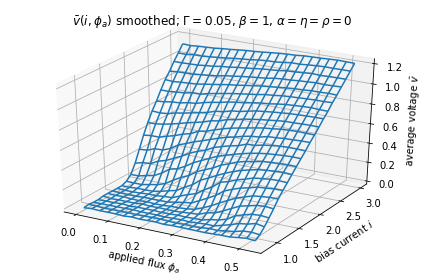

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')
#x = np.copy(i)
#y = np.copy(phia)
#x, y = np.meshgrid(y, x)
#z = np.copy(ivi)
ax.plot_wireframe(xnew, ynew, ivi) # cmap='terrain'
# note the xlabel and ylabel are reversed, this is correct
ax.set(ylabel=r'bias current $i$',
       xlabel=r'applied flux $\phi_a$',
       zlabel=r'average voltage $\bar{v}$',
      title = r'$\bar{v}(i,\phi_a)$ smoothed; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$')
fig.tight_layout()
fig.savefig('test.jpg')

In [10]:
## Transfer function ##
# need partial dvbar/dphia as a function of i
# that is the transfer function

# first get derivative of surface vbar(i,phia)
# gradient() returns one surface of the value of the partial deriv
# for each dependent dimension. So two sets for us: dvbar/di and 
# dvbar/dphia. We are interested in the second here.


dv = np.gradient(ivi,inew,phianew) # bingo, dv[1] = dvbar(i,phia)/dphia
                     # dv[0] = dvbar(i,phia)/di

# Next we can peep the surface

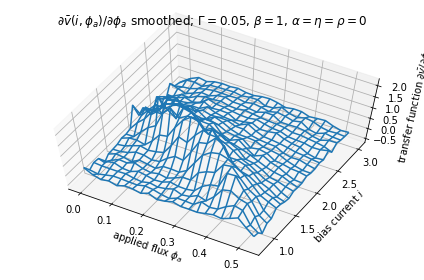

In [11]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x = np.copy(inew)
y = np.copy(phianew)
x, y = np.meshgrid(y, x)
z = np.copy(dv[1]) # partial dvbar/dphia
ax.plot_wireframe(x, y, z) # cmap='terrain'
# note the xlabel and ylabel are reversed, this is correct
ax.set(ylabel=r'bias current $i$',
       xlabel=r'applied flux $\phi_a$',
       zlabel=r'transfer function $\partial\bar{v}/\partial\phi_a$',
      title = r'$\partial\bar{v}(i,\phi_a)/\partial\phi_a$ smoothed; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$')
ax.view_init(65,-60)
fig.tight_layout()
fig.savefig('test.jpg')

# This looks correct to me

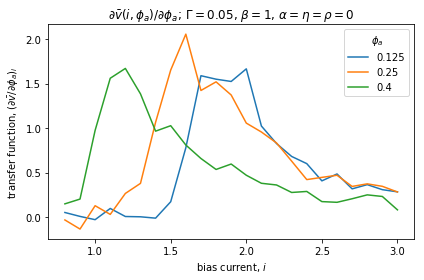

In [12]:
fig, ax = plt.subplots()
dv1 = np.copy(dv[1])
ax.plot(inew,dv1[:,int(5*l)],label=round(phianew[int(5*l)],3))
ax.plot(inew,dv1[:,int(10*l)],label=round(phianew[int(10*l)],3))
ax.plot(inew,dv1[:,int(-6*l)],label=round(phianew[int(-6*l)],3))
ax.set(title=r'$\partial \bar{v}(i,\phi_a)/\partial\phi_a$; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$',
      xlabel=r'bias current, $i$',
      ylabel=r'transfer function, $(\partial\bar{v}/\partial\phi_a)_i$')
ax.legend(title=r'$\phi_a$')
fig.tight_layout()